In [2]:
import pandas as pd
import psycopg2 as pg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import confusion_matrix,matthews_corrcoef,accuracy_score
import optuna
import pickle
from sklearn.feature_selection import SequentialFeatureSelector
reload_data = False
def norm(x):
    if len(x)==1 and x[0]=='':
        return []
    else:
        return x
if reload_data:
    engine = pg.connect("dbname='safeidx' user='fbk_mpba' host='172.104.247.67' port='5432' password='fbk2024$'")
    df = pd.read_sql('select * from fbk_export_20240212', con=engine) 
    with open('../src/data.pkl','wb') as f:
        pickle.dump(df,f)
else:
    with open('../src/data.pkl','rb') as f:
        df = pickle.load(f)


/tmp/ipykernel_20879/1378035245.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/agobbi/miniconda3/envs/pid/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
100-100*df[pd.isnull(df.india)].shape[0]/df.shape[0]

12.270580319372186

In [4]:
df[~pd.isnull(df.india)].shape[0] 

18419

In [5]:
df.shape

(150107, 22)

In [6]:
## these columns can lead to overfit!
df.drop(columns=['dateandtime','skiarea_id','day_of_year','minute_of_day','year'], inplace=True)

In [7]:
df

skiarea_name  season    difficulty             cause  \
0                     Pampeago    2009        novice        fall_alone   
1                     Pampeago    2009      advanced        fall_alone   
2                     Pampeago    2009      advanced        fall_alone   
3                     Pampeago    2009      advanced  collision_person   
4                     Pampeago    2009      advanced  collision_person   
...                        ...     ...           ...               ...   
150102              Speikboden    2024  intermediate        fall_alone   
150103            Bardonecchia    2024          easy        fall_alone   
150104               Klausberg    2024          easy  collision_person   
150105             Moena Lusia    2024  intermediate        fall_alone   
150106  Porta Vescovo - Arabba    2024  intermediate        fall_alone   

                                           town province gender equipment  \
0                                        SIKLOS               F       ski   
1                                         MALMO               M       ski   
2                                       CALDARO       BZ      F       ski   
3                                          LINZ               M       ski   
4                                        RUSAVA               M       ski   
...                                         ...      ...    ...       ...   
150102  Dettmannsdorf OT Dettmannsdorf - Kölzow     None      F       ski   
150103                                   Milano   Milano      M       ski   
150104                               Düsseldorf     None      F       ski   
150105                                   Rimini   Rimini      F       ski   
150106                            Busto Garolfo   Milano      F       ski   

       helmet              destination   diagnosis india   age  \
0        None  hospital_emergency_room  distortion  None  32.0   
1        None  hospital_emergency_room      bruise  None  32.0   
2        None                 domicile       other  None  12.0   
3        None  hospital_emergency_room      bruise  None  58.0   
4        None                    other      bruise  None  25.0   
...       ...                      ...         ...   ...   ...   
150102   True  hospital_emergency_room       other    i2  37.0   
150103   True                     None       wound  None  33.0   
150104   True             traumacenter       other    i2  66.0   
150105   True                 domicile      bruise  None  14.0   
150106   True                 domicile  distortion  None  58.0   

                country injury_side injury_general_location  \
0              Ungheria           L             lower_limbs   
1                Svezia           R           skull_or_face   
2                Italia           R                    None   
3               Austria           R             lower_limbs   
4       Repubblica Ceca           L             lower_limbs   
...                 ...         ...                     ...   
150102         Germania           L             lower_limbs   
150103           Italia           L             upper_limbs   
150104         Germania           L             upper_limbs   
150105           Italia           R             lower_limbs   
150106           Italia           L             lower_limbs   

                  evacuation_vehicles  
0                              [akja]  
1                              [akja]  
2                        [snowmobile]  
3                        [snowmobile]  
4                             [other]  
...                               ...  
150102  [snowmobile_sled, helicopter]  
150103                [indipendently]  
150104    [car, ski_lift, snowmobile]  
150105         [ski_lift, snowmobile]  
150106                         [akja]  

[150107 rows x 17 columns]

In [8]:
##evacuation_vehicles must be explicitated
ev = set({})
for i,row in df.iterrows():
    ev = ev.union(set(row.evacuation_vehicles))
for c in ev:
    df[c] = False
for i,row in df.iterrows():
    for c in row.evacuation_vehicles:
        df.loc[i,c] = True
df.drop(columns=['town','province','evacuation_vehicles'],inplace=True)



In [9]:
df.columns

Index(['skiarea_name', 'season', 'difficulty', 'cause', 'gender', 'equipment',
       'helmet', 'destination', 'diagnosis', 'india', 'age', 'country',
       'injury_side', 'injury_general_location', 'snowmobile', 'other', 'akja',
       'offroad_vehicle', 'ski_lift', 'skiarea_ambulance', 'quad',
       'privat_helicopter', 'ambulance', 'car', 'snowmobile_sled',
       'indipendently', 'helicopter'],
      dtype='object')

In [22]:
aa

india  count
0    i0    850
1    i1  13899
2    i2   3416
3    i3    154
4    i4     11

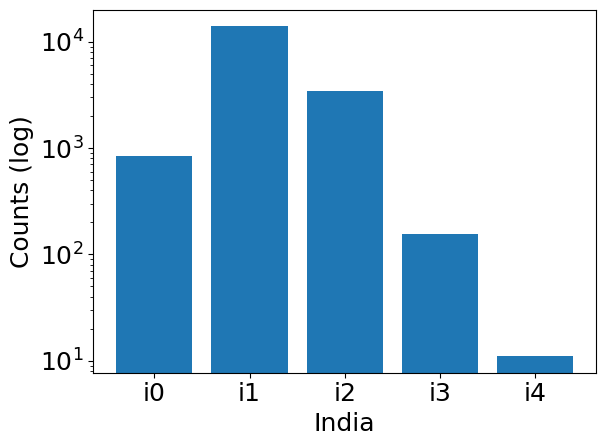

In [33]:
aa = labeled.groupby('india').age.count().reset_index().rename(columns={'age':'Nsamples'})
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

plt.bar(aa.india, aa.Nsamples,log=True)
plt.xlabel('India')
plt.ylabel('Counts (log)')
plt.tight_layout()
plt.savefig('counts.png')


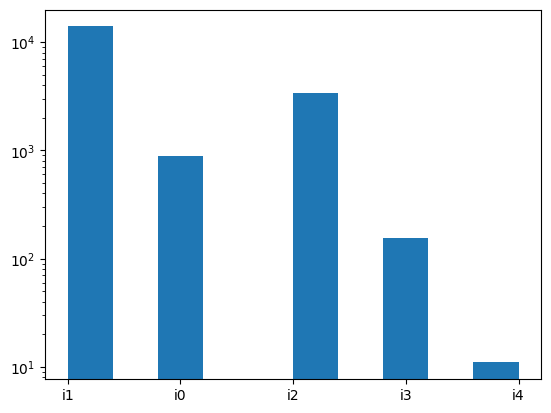

In [17]:
#plot india distribution
labeled = df[~pd.isna(df.india)].reset_index().drop(columns='index')
labeled['age'] =  labeled['age'].astype(np.float32).fillna(np.nan)
plt.hist(labeled.india,log=True);


In [54]:
labeled.head()

skiarea_name  season    difficulty       cause gender equipment helmet  \
0    Kronplatz    2018          None  fall_alone      F       ski   True   
1    Kronplatz    2018          easy     illness      M       ski   True   
2    Kronplatz    2018      advanced  fall_alone      M       ski   True   
3    Kronplatz    2018      advanced  fall_alone      M       ski   True   
4    Kronplatz    2018  intermediate  fall_alone      M       ski   True   

               destination   diagnosis  india  ...  ambulance  \
0  hospital_emergency_room  distortion      1  ...      False   
1                 domicile       other      0  ...      False   
2  hospital_emergency_room       wound      1  ...      False   
3  hospital_emergency_room    fracture      1  ...      False   
4  hospital_emergency_room       other      1  ...      False   

  privat_helicopter skiarea_ambulance snowmobile   quad helicopter   akja  \
0             False             False       True  False      False  False   
1             False             False      False  False      False  False   
2             False             False      False  False      False   True   
3             False             False      False  False      False   True   
4             False             False      False  False      False   True   

  offroad_vehicle  other indipendently  
0           False  False         False  
1           False  False         False  
2           False  False         False  
3           False  False         False  
4           False  False         False  

[5 rows x 27 columns]

In [38]:
labeled.groupby(c)[c].count().shape

(5,)

In [39]:
for c in labeled.columns:
    if c not in ['india','age','season','skiarea_name']:
        labeled[c] = labeled[c].astype('str')  
        print(c,labeled.groupby(c)[c].count().shape[0])

difficulty 5
cause 10
gender 3
equipment 12
helmet 3
destination 9
diagnosis 32
country 75
injury_side 3
injury_general_location 5
snowmobile 2
other 2
akja 2
offroad_vehicle 2
ski_lift 2
skiarea_ambulance 2
quad 2
privat_helicopter 2
ambulance 2
car 2
snowmobile_sled 2
indipendently 2
helicopter 2


/tmp/ipykernel_69977/944685202.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


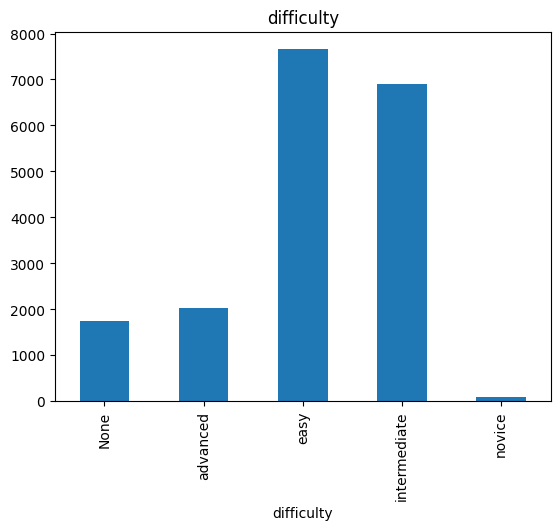

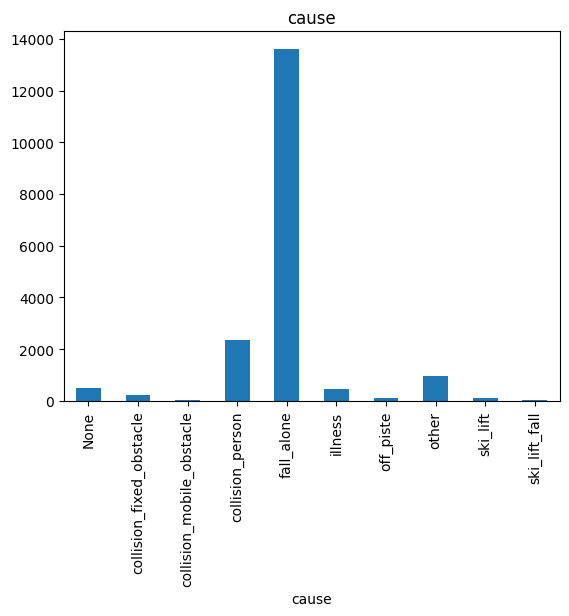

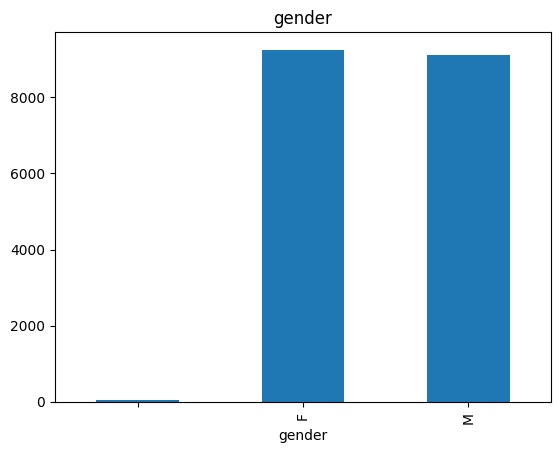

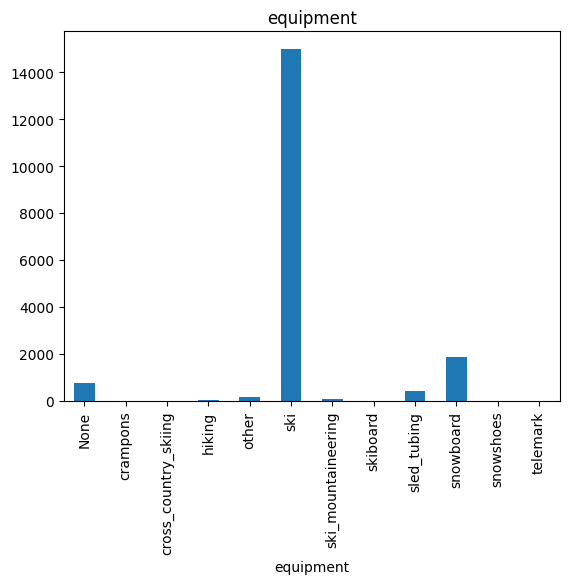

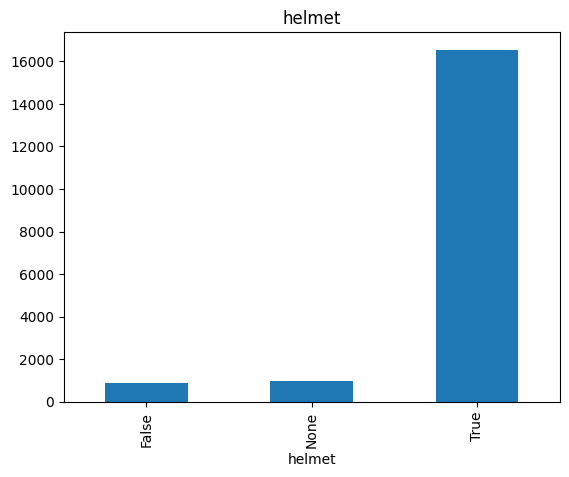

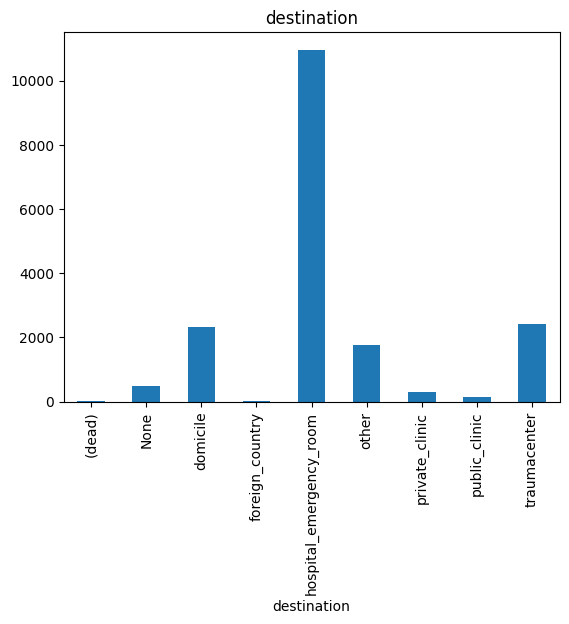

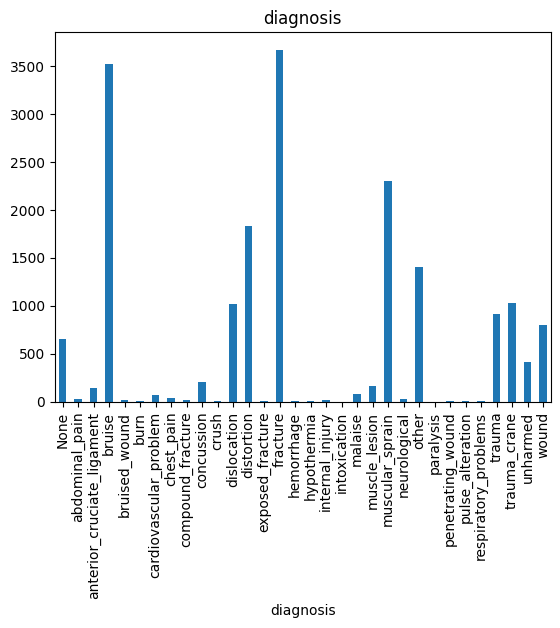

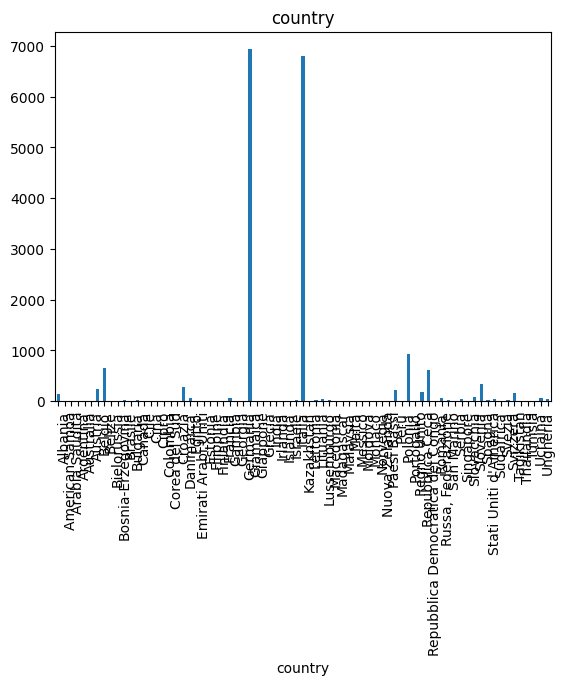

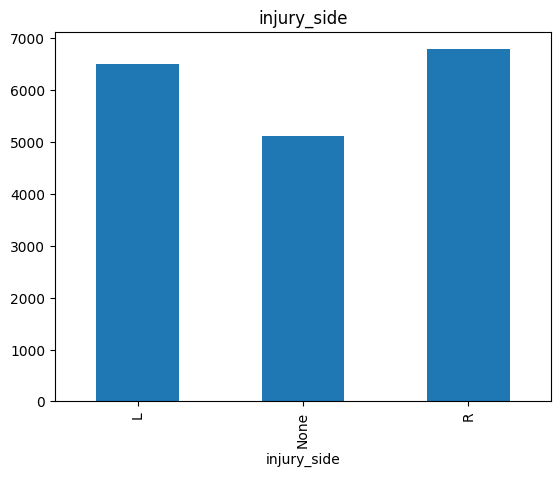

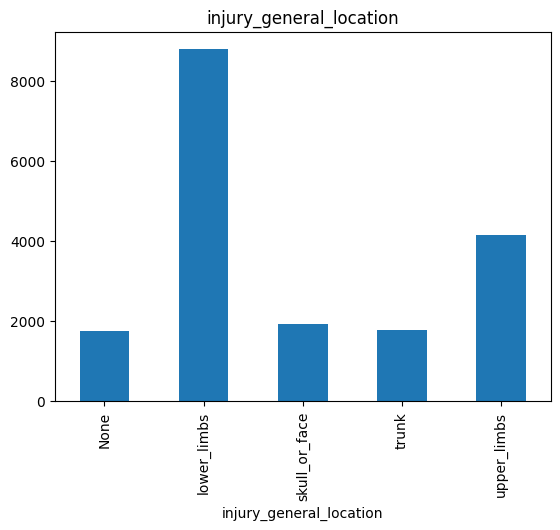

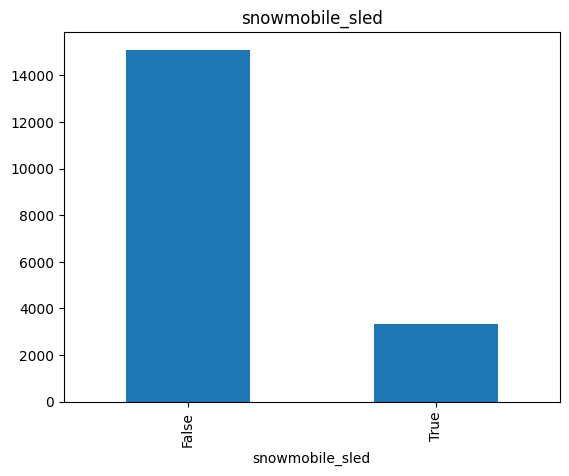

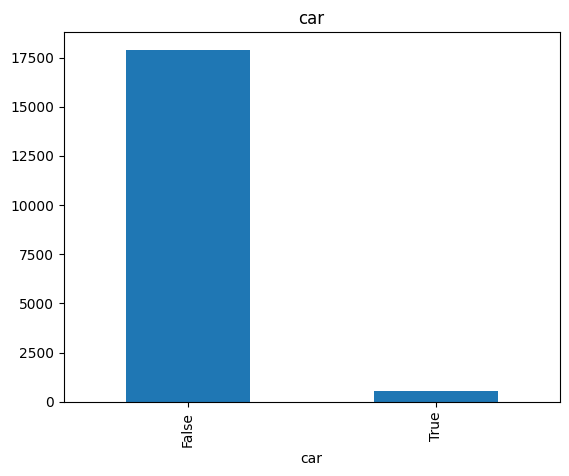

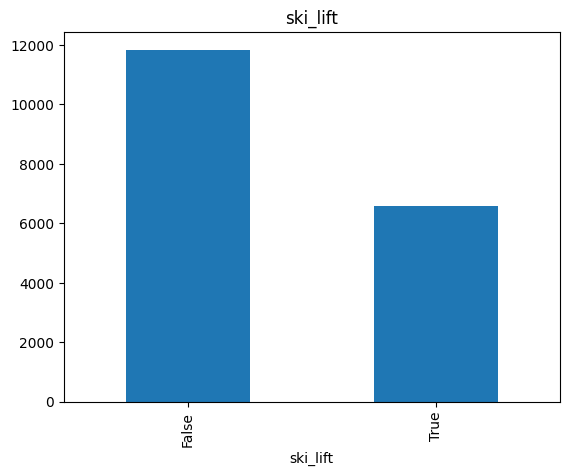

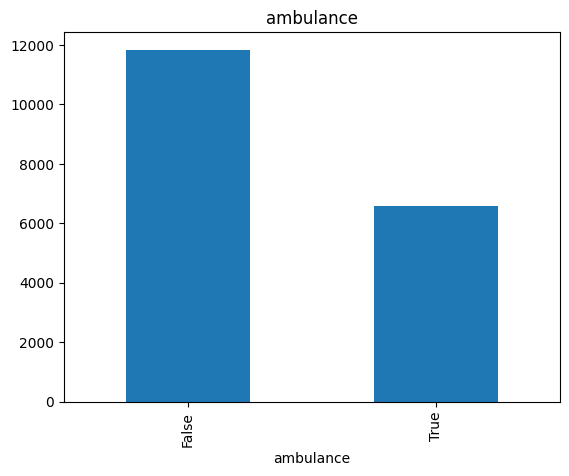

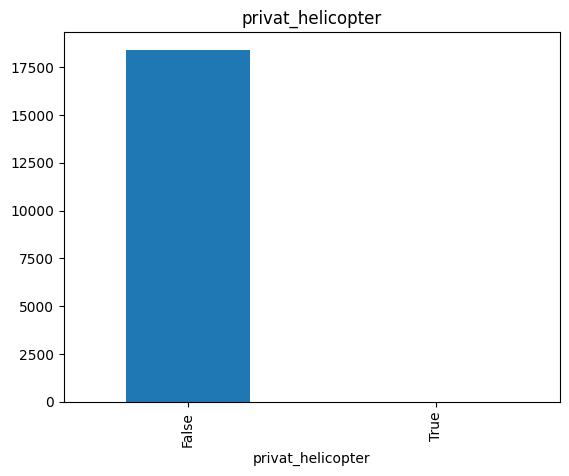

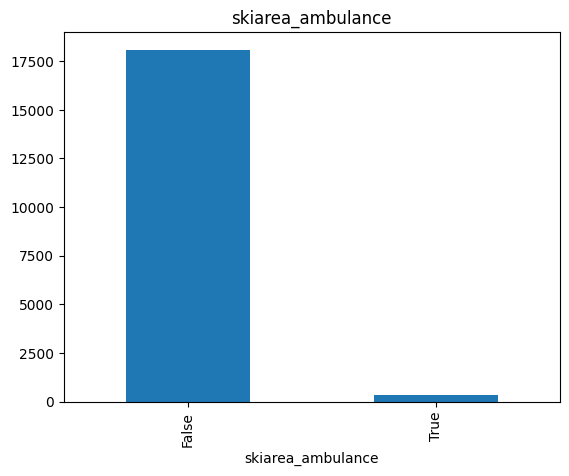

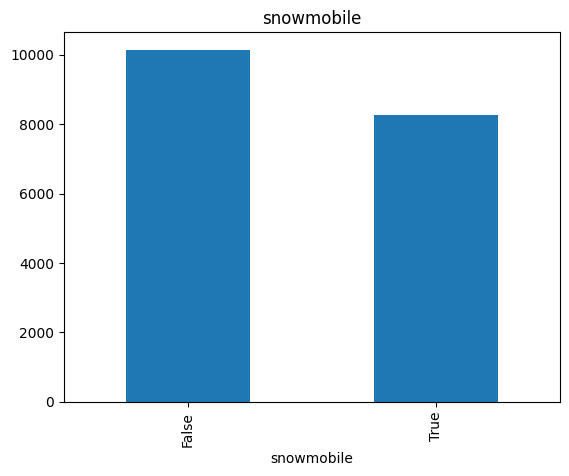

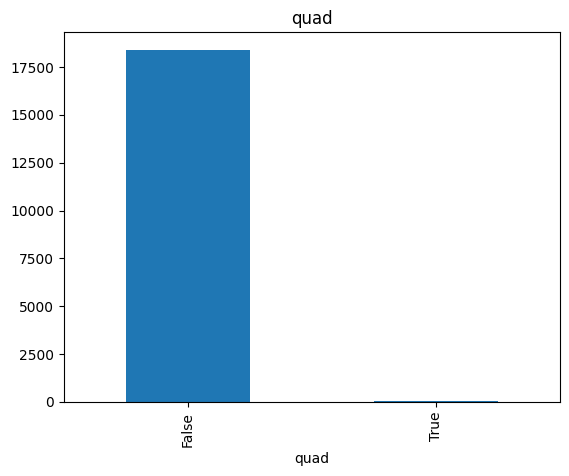

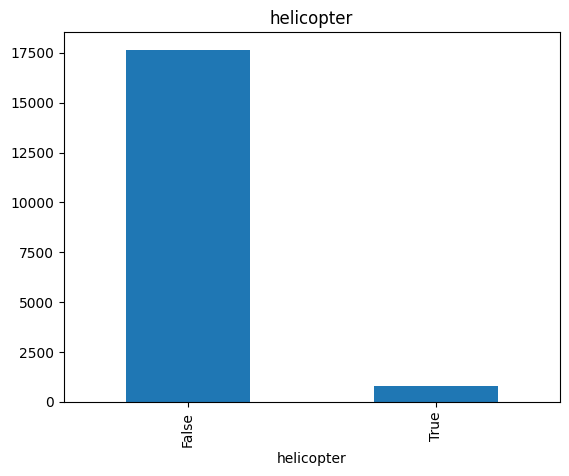

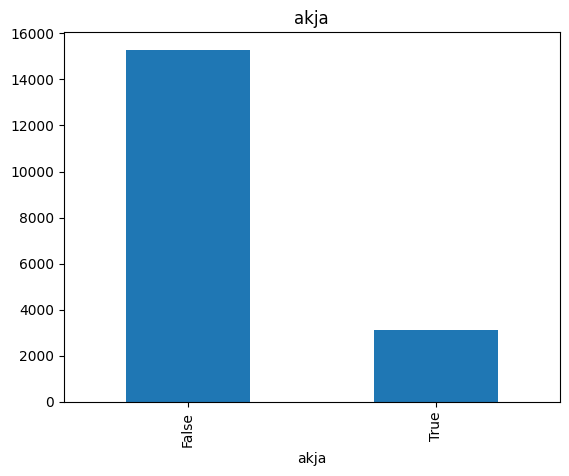

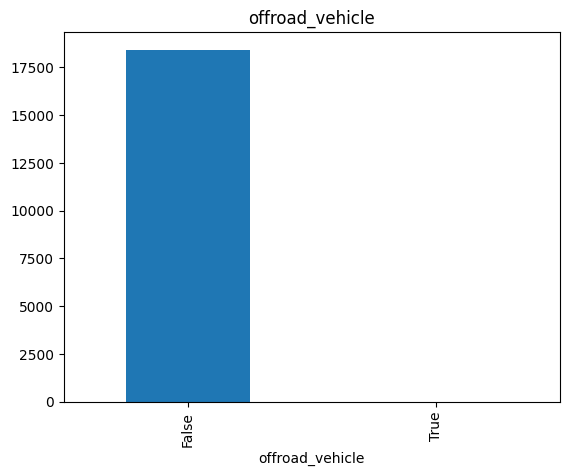

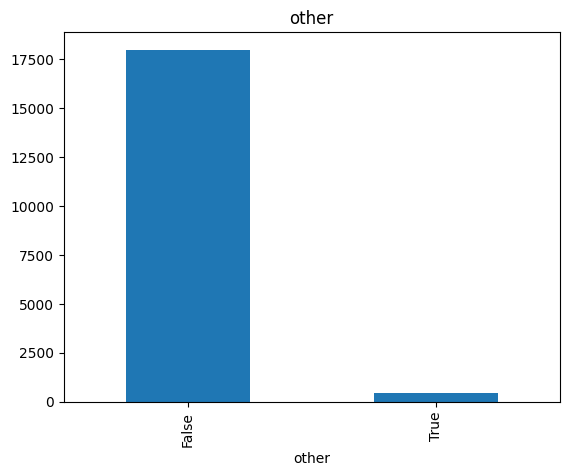

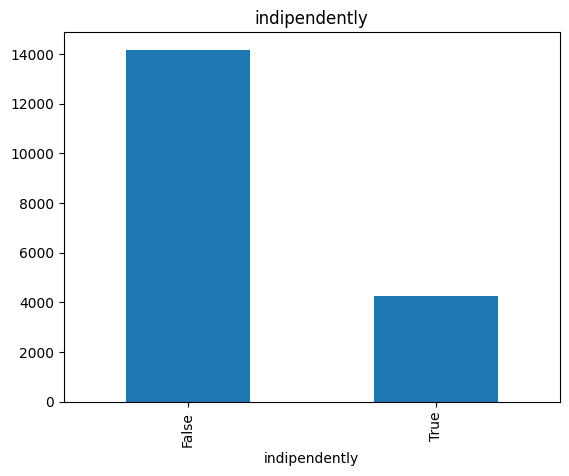

In [8]:
## plot of categorical variables, there are some under-represented categories, 
## maybe it is possible to obtain a more stable model removing such classes
to_remove = {}
TH = 0.5
for c in labeled.columns:
    if c not in ['india','age','season','skiarea_name']:
        labeled[c] = labeled[c].astype('str')  
        plt.figure()
        labeled.groupby(c)[c].count().plot(kind='bar')
        plt.title(c)
        tmp = labeled.groupby(c)[c].count()
        tmp = 100*tmp/tmp.max()
        tmp = tmp[tmp<TH]
        if len(tmp)>0:
            for k in tmp.index:
                if c not in to_remove.keys():
                    to_remove[c]= []
                to_remove[c].append(k)

In [9]:
labeled_small = labeled.copy()
for c in to_remove.keys():
    for k in to_remove[c]:
        labeled_small.loc[labeled_small[c]==k,c] = 'other'
for c in labeled_small.columns:
    if c not in ['age','season','skiarea_name']:
        labeled_small[c] =  labeled_small[c].fillna('None').astype('category')  
        labeled[c] =  labeled[c].fillna('None').astype('category')
labeled.dropna(inplace=True)
labeled_small.dropna(inplace=True)

/tmp/ipykernel_69977/134691014.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labeled_small.groupby(c)[c].count().plot(kind='bar')
/tmp/ipykernel_69977/134691014.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labeled_small.groupby(c)[c].count().plot(kind='bar')
/tmp/ipykernel_69977/134691014.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labeled_small.groupby(c)[c].count().plot(kind='bar')
/tmp/ipykernel_6

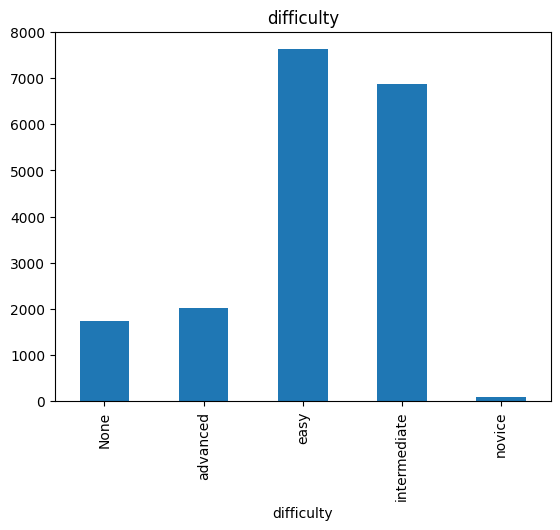

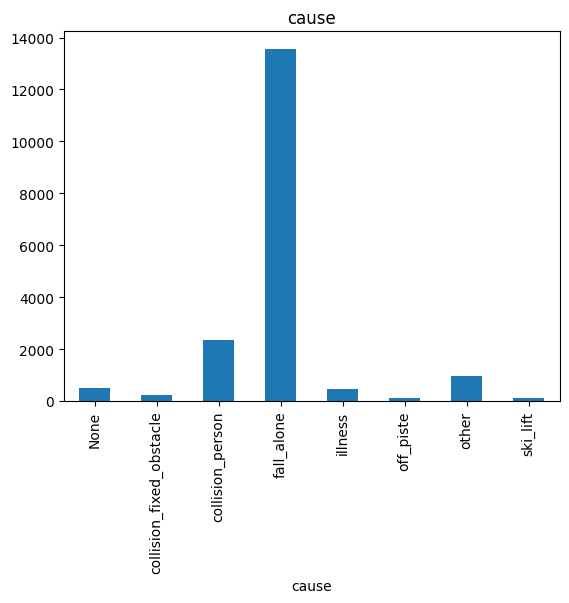

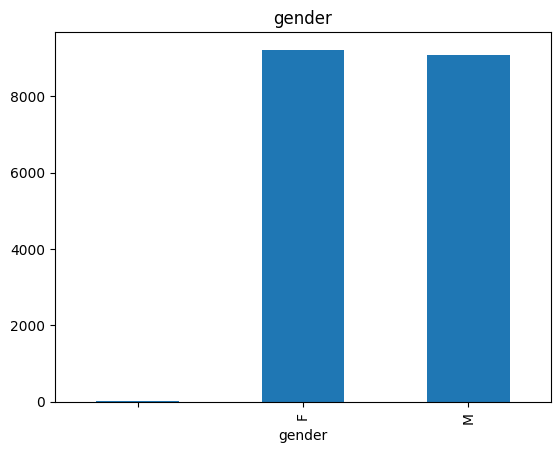

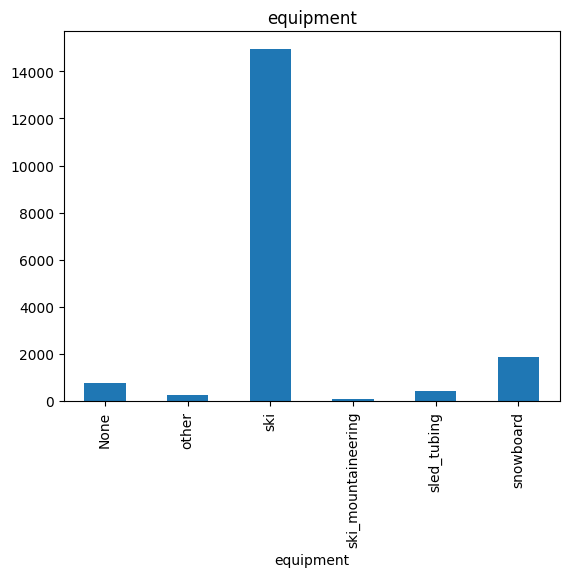

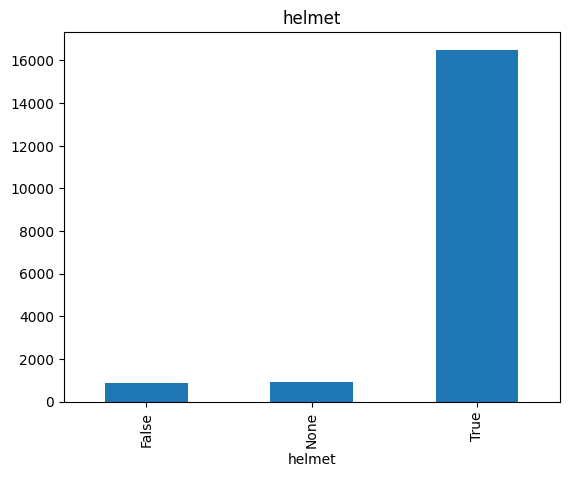

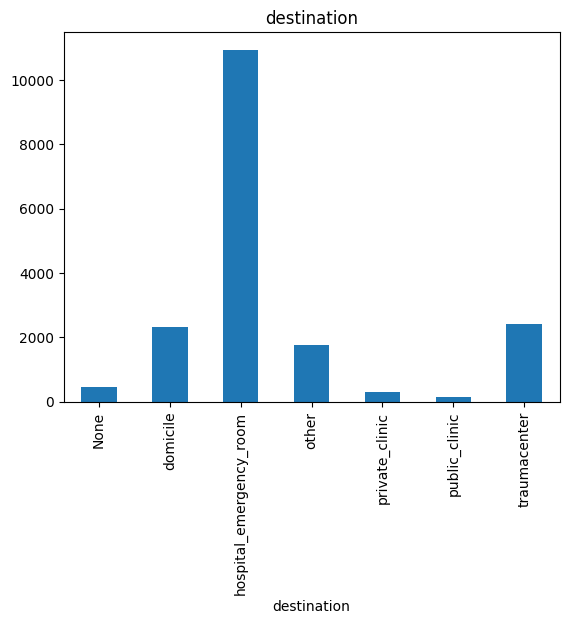

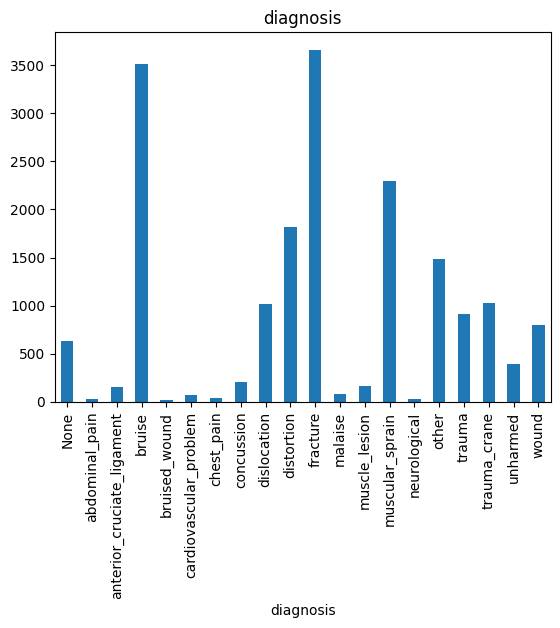

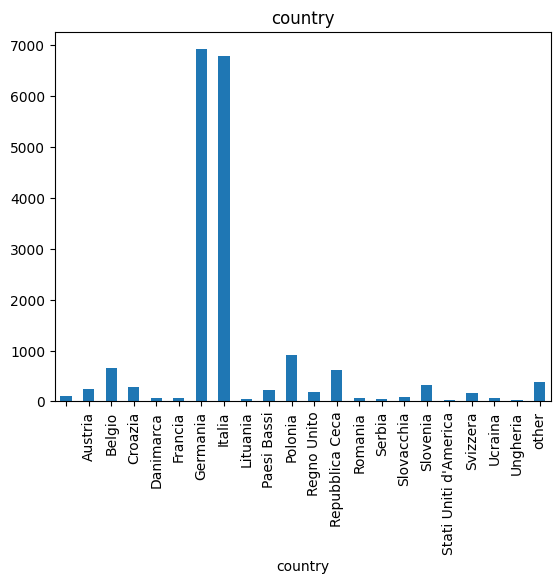

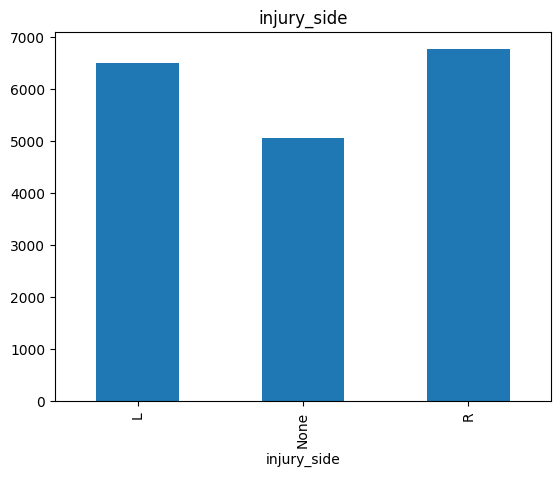

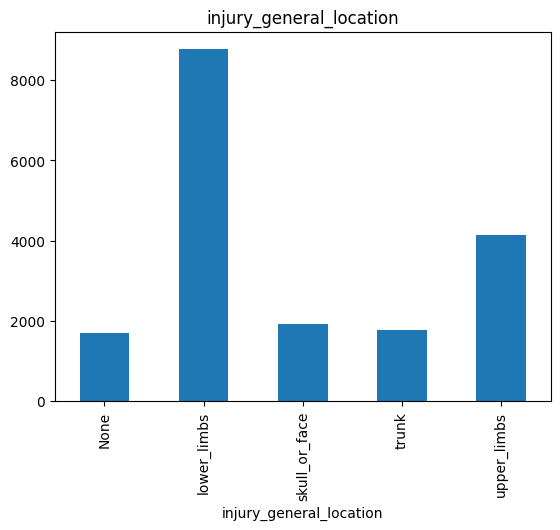

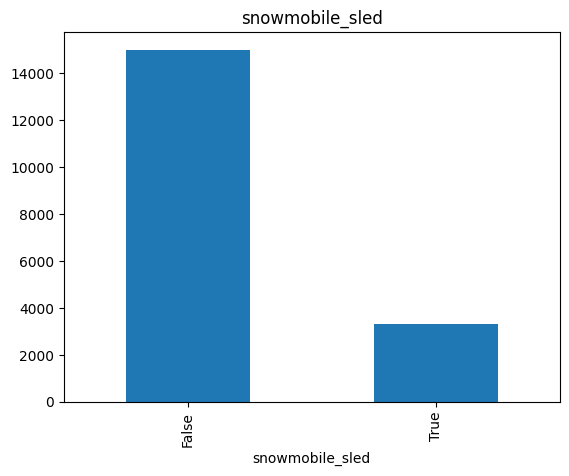

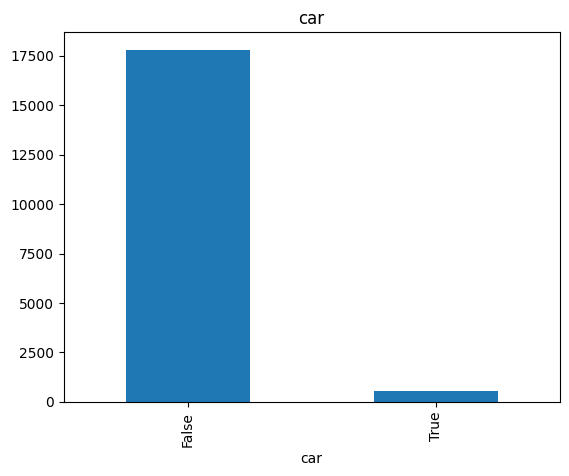

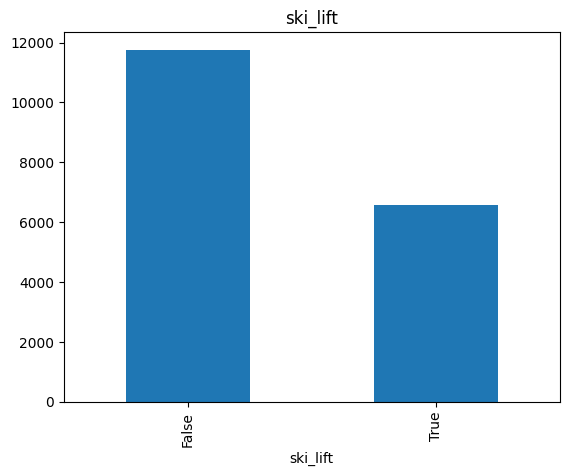

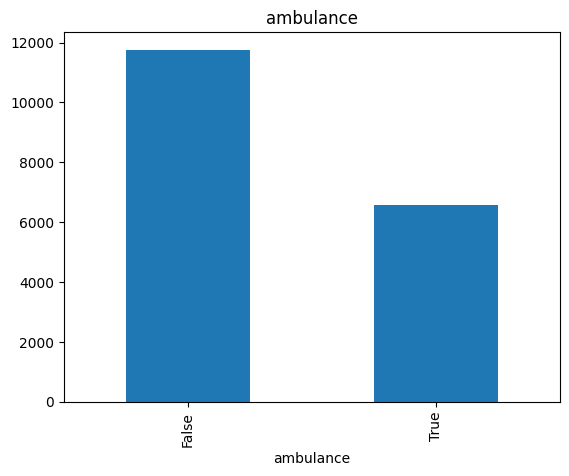

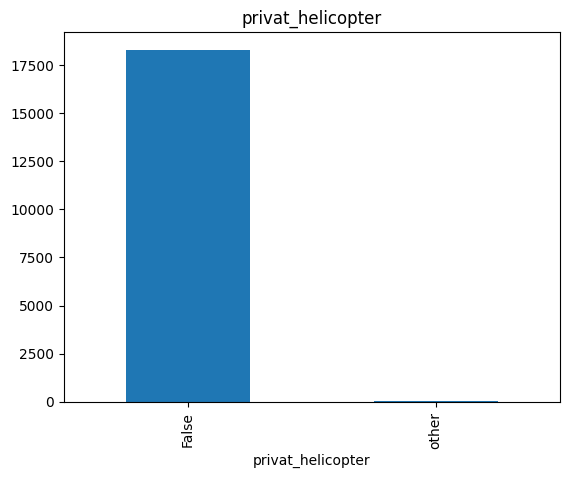

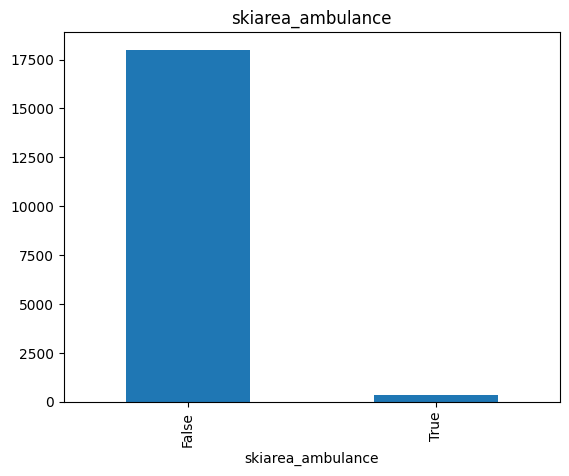

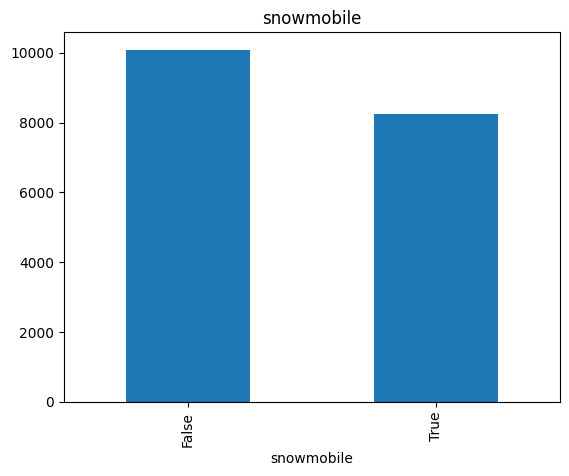

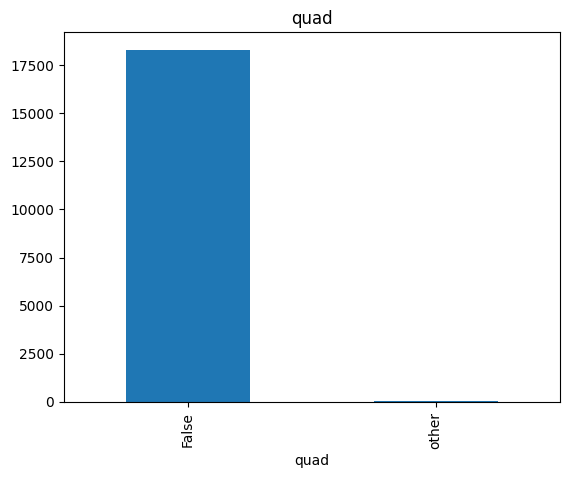

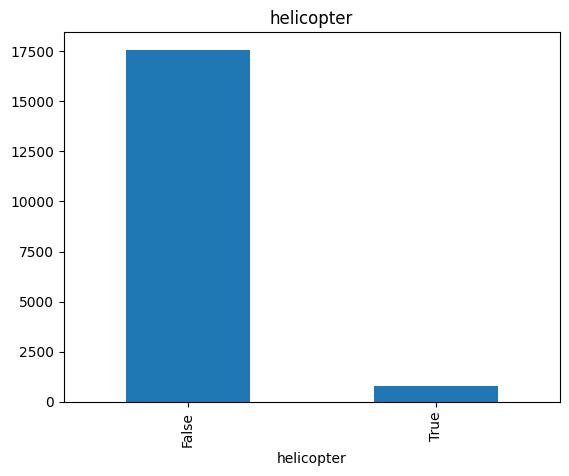

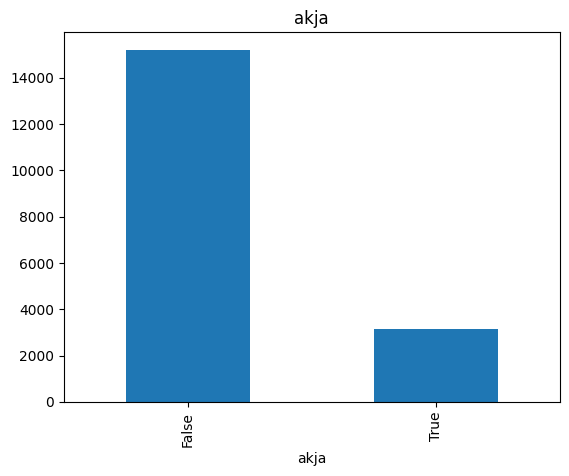

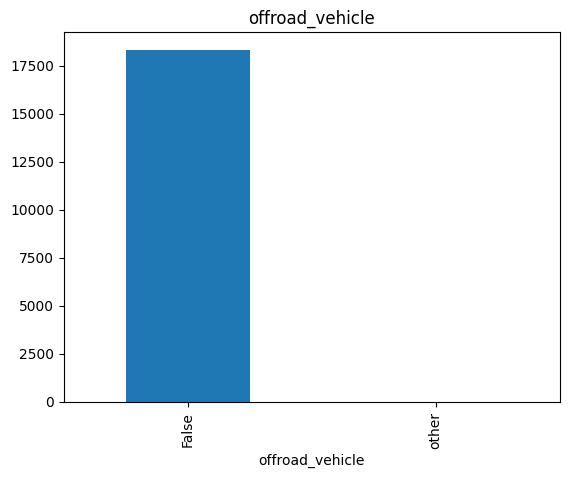

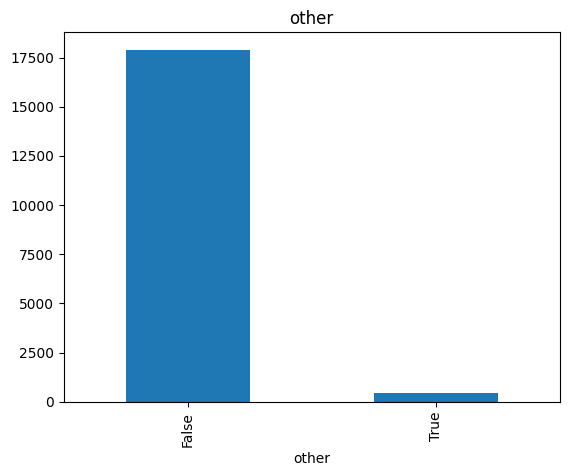

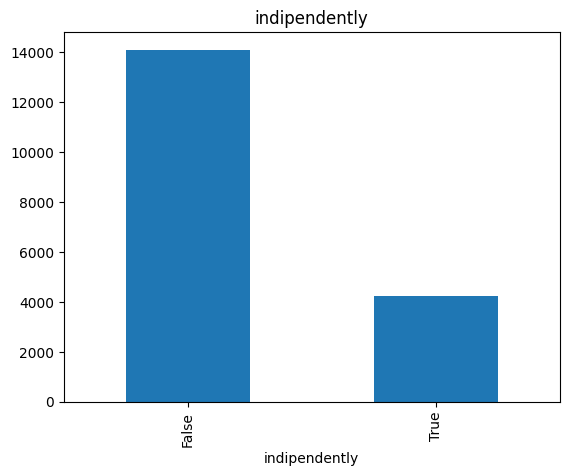

In [10]:
for c in labeled_small.columns:
    if c not in ['india','age','season','skiarea_name']:
        plt.figure()
        labeled_small.groupby(c)[c].count().plot(kind='bar')
        plt.title(c)

    

In [11]:
labeled.head()

skiarea_name  season    difficulty       cause gender equipment helmet  \
0    Kronplatz    2018          None  fall_alone      F       ski   True   
1    Kronplatz    2018          easy     illness      M       ski   True   
2    Kronplatz    2018      advanced  fall_alone      M       ski   True   
3    Kronplatz    2018      advanced  fall_alone      M       ski   True   
4    Kronplatz    2018  intermediate  fall_alone      M       ski   True   

               destination   diagnosis india  ...  ambulance  \
0  hospital_emergency_room  distortion    i1  ...      False   
1                 domicile       other    i0  ...      False   
2  hospital_emergency_room       wound    i1  ...      False   
3  hospital_emergency_room    fracture    i1  ...      False   
4  hospital_emergency_room       other    i1  ...      False   

  privat_helicopter skiarea_ambulance snowmobile   quad helicopter   akja  \
0             False             False       True  False      False  False   
1             False             False      False  False      False  False   
2             False             False      False  False      False   True   
3             False             False      False  False      False   True   
4             False             False      False  False      False   True   

  offroad_vehicle  other indipendently  
0           False  False         False  
1           False  False         False  
2           False  False         False  
3           False  False         False  
4           False  False         False  

[5 rows x 27 columns]

In [21]:
labeled.india = labeled.india.apply(lambda x: x.replace('i','')).astype(int)
labeled_small.india = labeled_small.india.apply(lambda x: x.replace('i','')).astype(int)

In [22]:
##TEST 
SKI_AREA_TEST = 'Klausberg'
SEASON_TEST_SKIAREA = 'Kronplatz'
SEASON_TEST_YEAR = 2023 ##2023-2024
test_area = labeled[labeled.skiarea_name==SKI_AREA_TEST]
test_area_small = labeled_small[labeled_small.skiarea_name==SKI_AREA_TEST]
print(test_area_small.shape)
test_area_season = labeled[(labeled.skiarea_name==SEASON_TEST_SKIAREA)&(labeled.season>=SEASON_TEST_YEAR)]
test_area_season_small = labeled_small[(labeled_small.skiarea_name==SEASON_TEST_SKIAREA)&(labeled_small.season>=SEASON_TEST_YEAR)]
print(test_area_season_small.shape)


(2034, 27)
(2183, 27)


In [23]:

labeled_tmp = labeled[labeled.skiarea_name!=SKI_AREA_TEST]
labeled_tmp = labeled_tmp[(labeled_tmp.skiarea_name!=SEASON_TEST_SKIAREA)|(labeled_tmp.season<SEASON_TEST_YEAR) ]
X_train, X_valid, y_train, y_valid = train_test_split( labeled_tmp.drop(columns=['india','season','skiarea_name']),
                                                    labeled_tmp.india, test_size=0.33, random_state=0,stratify=labeled_tmp.india)

labeled_small_tmp = labeled_small[labeled_small.skiarea_name!=SKI_AREA_TEST]
labeled_small_tmp = labeled_small_tmp[(labeled_small_tmp.skiarea_name!=SEASON_TEST_SKIAREA)|(labeled_small_tmp.season<SEASON_TEST_YEAR) ]
X_train_small, X_valid_small, y_train_small, y_valid_small = train_test_split( labeled_small_tmp.drop(columns=['india','season','skiarea_name']),
                                                    labeled_small_tmp.india, test_size=0.33, random_state=0,stratify=labeled_small_tmp.india)

In [24]:
use_smote = False
if use_smote:
    from imblearn.over_sampling import RandomOverSampler
    
    sm = RandomOverSampler()
    X_train_smote,y_train_smote = sm.fit_resample(X_train,y_train)
    X_train_smote_small,y_train_smote_small = sm.fit_resample(X_train_small,y_train_small)

In [25]:
w = pd.DataFrame(np.unique(y_train,return_counts=True)).T
w.columns = ['class','p']
w.p = np.sqrt(w.p.sum())/w.p
print(w)
weight_train = pd.merge(pd.DataFrame({'class':y_train}),w).p.values


   class          p
0      0   0.203424
1      1   0.013596
2      2   0.056109
3      3   1.130661
4      4  16.206137


In [26]:
##THIS IS BETTER
#w = pd.DataFrame(np.unique(y_train,return_counts=True)).T
#w.columns = ['class','p']
#w.p = w.p.sum()/w.p/w.shape[0]
#print(w)
#weight_train = pd.merge(pd.DataFrame({'class':y_train}),w).p.values
#weight_train

In [58]:
weight_train

array([0.01359575, 0.05610896, 0.01359575, ..., 0.20342432, 0.05610896,
       0.05610896])

In [55]:

def objective(trial,X_train,y_train,X_valid,y_valid,weight_train):
    params = dict(
                learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2),
                max_depth= trial.suggest_int("max_depth",5, 15),
                min_child_weight = trial.suggest_int("min_child_weight", 1, 8),
                gamma = trial.suggest_float("gamma", 0, 10),
                subsample = trial.suggest_float("subsample", 0.01,1),
                colsample_bytree = trial.suggest_float("colsample_bytree", 0.01,1),
                alpha = trial.suggest_float("alpha", 0, 10),
                objective= 'multi:softprob', 
                nthread=4, 
                 num_class= 5,
                seed=27)
    params['lambda'] = trial.suggest_float("lambda", 0, 10)

    
    dtrain = xgb.DMatrix(X_train,y_train, 
                         enable_categorical=True,
                         weight=weight_train)
    dvalid = xgb.DMatrix(X_valid,y_valid,
                         enable_categorical=True,
                         )


    bst = xgb.train(params, dtrain,verbose_eval=False, num_boost_round=600,
                    evals = [(dtrain, "train"), (dvalid, "valid")],
                    early_stopping_rounds=100)

    preds = bst.predict(dvalid)
    ##MCC is more solid
    mcc = matthews_corrcoef(y_valid,preds.argmax(1))    
    
    return mcc



study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial,X_train,y_train,X_valid,y_valid,weight_train), n_trials=1000, timeout=600,)

params_final = dict(
            objective= 'multi:softprob', 
            nthread=4, 
             num_class= 5,
            seed=27)
params_final.update(study.best_params)
dtrain = xgb.DMatrix(X_train,y_train, 
                     enable_categorical=True,
                     weight=weight_train)
dvalid = xgb.DMatrix(X_valid,y_valid,
                     enable_categorical=True,
                     )   
bst = xgb.train(params_final, dtrain,verbose_eval=False, num_boost_round=600,
                evals = [(dtrain, "train"), (dvalid, "valid")],
                early_stopping_rounds=100,)


[I 2024-02-19 10:13:34,770] A new study created in memory with name: no-name-eb45f3a5-a8c6-45fe-a5a1-a9a50593fb27
[I 2024-02-19 10:13:35,613] Trial 0 finished with value: 0.1989111911567868 and parameters: {'learning_rate': 0.069550503828446, 'max_depth': 14, 'min_child_weight': 4, 'gamma': 6.840625787856297, 'subsample': 0.6425250659956084, 'colsample_bytree': 0.8479444601860839, 'alpha': 7.62883839298031, 'lambda': 4.463721336424616}. Best is trial 0 with value: 0.1989111911567868.
[I 2024-02-19 10:13:36,882] Trial 1 finished with value: 0.3173094420130114 and parameters: {'learning_rate': 0.03760597869350516, 'max_depth': 14, 'min_child_weight': 1, 'gamma': 4.912637931042977, 'subsample': 0.4614006609002679, 'colsample_bytree': 0.6144190767209258, 'alpha': 1.3722886308582516, 'lambda': 4.119799280632812}. Best is trial 1 with value: 0.3173094420130114.
[I 2024-02-19 10:13:38,133] Trial 2 finished with value: 0.36354566542920486 and parameters: {'learning_rate': 0.029446413231195095,

In [28]:

def objective_small(trial):#,X_train,y_train,X_valid,y_valid,weight_train):
    params = dict(
                #booster = trial.suggest_categorical("booster",['gbtree', 'gblinear', 'dart']),
                learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2),
                max_depth= trial.suggest_int("max_depth",5, 15),
                min_child_weight = trial.suggest_int("min_child_weight", 1, 8),
                gamma = trial.suggest_float("gamma", 0, 10),
                subsample = trial.suggest_float("subsample", 0.01,1),
                colsample_bytree = trial.suggest_float("colsample_bytree", 0.01,1),
                alpha = trial.suggest_float("alpha", 0, 10),
                objective= 'multi:softprob', 
                nthread=4, 
                 num_class= 5,
                seed=27)
    params['lambda'] = trial.suggest_float("lambda", 0, 10)

    
    dtrain = xgb.DMatrix(X_train_small,y_train_small, 
                         enable_categorical=True,
                         weight=weight_train)
    dvalid = xgb.DMatrix(X_valid_small,y_valid_small,
                         enable_categorical=True,
                         )


    bst = xgb.train(params, dtrain,verbose_eval=False, num_boost_round=600,
                    evals = [(dtrain, "train"), (dvalid, "valid")],
                    early_stopping_rounds=100)

    preds = bst.predict(dvalid)
    ##MCC is more solid
    mcc = matthews_corrcoef(y_valid_small,preds.argmax(1))    
    
    return mcc



study_small = optuna.create_study(direction="maximize")
study_small.optimize(objective_small, n_trials=1000, timeout=600)
params_final = dict(
            objective= 'multi:softprob', 
            nthread=4, 
             num_class= 5,
            seed=27)
params_final.update(study_small.best_params)
dtrain_small = xgb.DMatrix(X_train_small,y_train_small, 
                     enable_categorical=True,
                     weight=weight_train)
dvalid_small = xgb.DMatrix(X_valid_small,y_valid_small,
                     enable_categorical=True,
                     )   
bst_small = xgb.train(params_final, dtrain_small,verbose_eval=False, num_boost_round=600,
                evals = [(dtrain_small, "train"), (dvalid_small, "valid")],
                early_stopping_rounds=100,)


[I 2024-02-12 16:16:47,769] A new study created in memory with name: no-name-49cc3e7a-a081-45be-88c6-7bf32f094399
[I 2024-02-12 16:16:47,978] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 0.05491468823977778, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 7.0040114746112145, 'subsample': 0.04250317969539257, 'colsample_bytree': 0.5947297992544279, 'alpha': 2.5510124618789054, 'lambda': 5.6437883532023765}. Best is trial 0 with value: 0.0.
[I 2024-02-12 16:16:48,793] Trial 1 finished with value: 0.31426941781461487 and parameters: {'learning_rate': 0.1461147252441012, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 9.744462681704128, 'subsample': 0.708376383454642, 'colsample_bytree': 0.771251938342384, 'alpha': 5.398629268029964, 'lambda': 5.948122996822612}. Best is trial 1 with value: 0.31426941781461487.
[I 2024-02-12 16:16:49,607] Trial 2 finished with value: 0.2651178596474042 and parameters: {'learning_rate': 0.021135907717799468, 'max_depth': 7, 'min_child_

In [29]:
if use_smote:
    def objective_small_smote(trial):#,X_train,y_train,X_valid,y_valid,weight_train):
        params = dict(
                    #booster = trial.suggest_categorical("booster",['gbtree', 'gblinear', 'dart']),
                    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2),
                    max_depth= trial.suggest_int("max_depth",5, 15),
                    min_child_weight = trial.suggest_int("min_child_weight", 1, 8),
                    gamma = trial.suggest_float("gamma", 0, 10),
                    subsample = trial.suggest_float("subsample", 0.01,1),
                    colsample_bytree = trial.suggest_float("colsample_bytree", 0.01,1),
                    alpha = trial.suggest_float("alpha", 0, 10),
                    objective= 'multi:softprob', 
                    nthread=4, 
                     num_class= 5,
                    seed=27)
        params['lambda'] = trial.suggest_float("lambda", 0, 10)
    
        
        dtrain = xgb.DMatrix(X_train_smote_small,y_train_smote_small, 
                             enable_categorical=True,)
        dvalid = xgb.DMatrix(X_valid_small,y_valid_small,
                             enable_categorical=True,
                             )
    
    
        bst = xgb.train(params, dtrain,verbose_eval=False, num_boost_round=400,
                        evals = [(dtrain, "train"), (dvalid, "valid")],
                        early_stopping_rounds=100)
    
        preds = bst.predict(dvalid)
        ##MCC is more solid
        mcc = matthews_corrcoef(y_valid_small,preds.argmax(1))    
        
        return mcc
    
    
    
    study_small = optuna.create_study(direction="maximize")
    study_small.optimize(objective_small, n_trials=200, timeout=600)
    params_final = dict(
                objective= 'multi:softprob', 
                nthread=4, 
                 num_class= 5,
                seed=27)
    params_final.update(study_small.best_params)
    dtrain_small = xgb.DMatrix(X_train_smote_small,y_train_smote_small, 
                         enable_categorical=True,
                      )
    dvalid_small = xgb.DMatrix(X_valid_small,y_valid_small,
                         enable_categorical=True,
                         )   
    bst_small = xgb.train(params_final, dtrain_small,verbose_eval=False, num_boost_round=400,
                    evals = [(dtrain_small, "train"), (dvalid_small, "valid")],
                    early_stopping_rounds=100,)


Text(0, 0.5, 'Feature Importance Score')

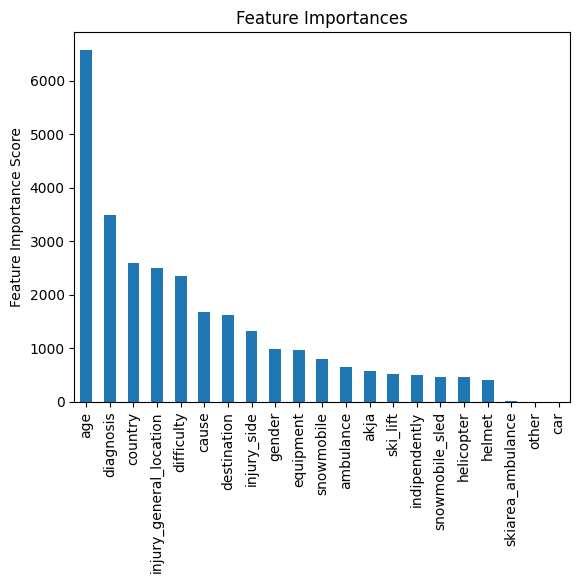

In [30]:
feat_imp = pd.Series(bst_small.get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [32]:
preds_class_valid = bst.predict(dvalid)
preds_class_train= bst.predict(dtrain)
print(confusion_matrix(y_valid,preds_class_valid.argmax(1)))
print(matthews_corrcoef(y_valid,preds_class_valid.argmax(1)))
print(accuracy_score(y_valid,preds_class_valid.argmax(1)))
print('########################################')
print(confusion_matrix(y_train,preds_class_train.argmax(1)))
print(matthews_corrcoef(y_train,preds_class_train.argmax(1)))
print(accuracy_score(y_train,preds_class_train.argmax(1)))

[[ 206   29    1    0    0]
 [ 224 2572  717   11    0]
 [  10  192  595   55    1]
 [   2    2   22   16    0]
 [   2    0    0    0    1]]
0.4669354220226053
0.7277801631601546
########################################
[[ 461   14    3    0    0]
 [ 433 5275 1408   36    0]
 [  10  251 1392   80    0]
 [   0    0    0   86    0]
 [   0    0    0    0    6]]
0.5578338794431741
0.7636171337916446


In [ ]:
if use_smote:
    preds_class_valid = bst_small.predict(dvalid_small)
    preds_class_train= bst_small.predict(dtrain_small)
    print(confusion_matrix(y_valid_small,preds_class_valid.argmax(1)))
    print(matthews_corrcoef(y_valid_small,preds_class_valid.argmax(1)))
    print(accuracy_score(y_valid_small,preds_class_valid.argmax(1)))
    print('########################################')
    print(confusion_matrix(y_train_smote_small,preds_class_train.argmax(1)))
    print(matthews_corrcoef(y_train_smote_small,preds_class_train.argmax(1)))
    print(accuracy_score(y_train_smote_small,preds_class_train.argmax(1)))

In [33]:

preds_class_valid = bst_small.predict(dvalid_small)
preds_class_train= bst_small.predict(dtrain_small)
print(confusion_matrix(y_valid_small,preds_class_valid.argmax(1)))
print(matthews_corrcoef(y_valid_small,preds_class_valid.argmax(1)))
print(accuracy_score(y_valid_small,preds_class_valid.argmax(1)))
print('########################################')
print(confusion_matrix(y_train_small,preds_class_train.argmax(1)))
print(matthews_corrcoef(y_train_small,preds_class_train.argmax(1)))
print(accuracy_score(y_train_small,preds_class_train.argmax(1)))

[[ 191   42    2    0    1]
 [ 161 2702  641   12    8]
 [   7  226  571   47    2]
 [   2    2   29    9    0]
 [   2    1    0    0    0]]
0.4671584355563095
0.7455989695148132
########################################
[[ 474    2    1    0    1]
 [ 261 5744 1115   28    4]
 [   3  188 1504   37    1]
 [   0    0    0   86    0]
 [   0    0    0    0    6]]
0.6559067720290881
0.8264410364886303


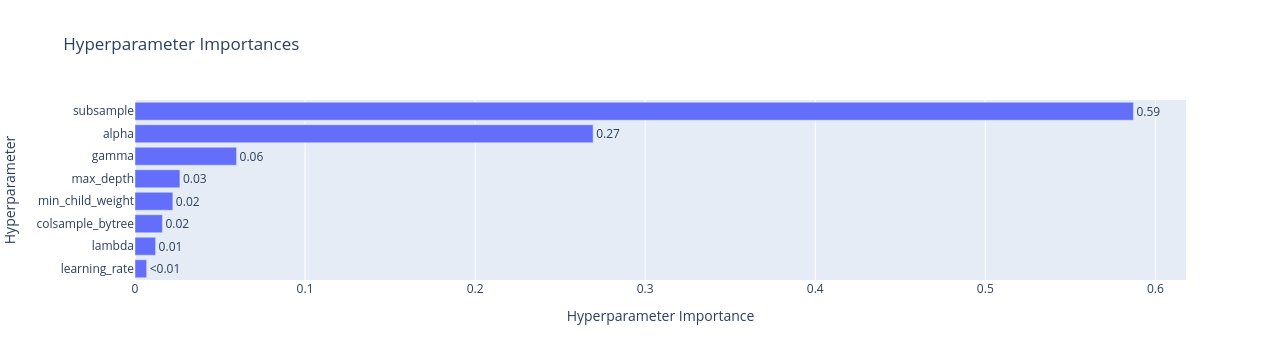

In [34]:
from optuna.visualization import plot_param_importances,plot_edf,plot_optimization_history
#plot_edf(study)
#plot_optimization_history(study)
with open('src/best_params.pkl','rb') as f:
    params_final,feat_imp,best_model,study = pickle.load(f)
plot_param_importances(study_small)

In [189]:
params_final

{'objective': 'multi:softprob',
 'nthread': 4,
 'num_class': 5,
 'seed': 27,
 'learning_rate': 0.06267938904293768,
 'max_depth': 14,
 'min_child_weight': 7,
 'gamma': 0.6199971726667972,
 'subsample': 0.8015724244693958,
 'colsample_bytree': 0.5064972828251288,
 'alpha': 0.11096589649454103,
 'lambda': 0.5753594958776281}

In [35]:
## me li salvo altrimenti ogni volta e' un casino
with open('best_params.pkl','wb') as f:
    pickle.dump([params_final,feat_imp],f)

In [36]:
with open('best_params.pkl','rb') as f:
    params_final,feat_imp = pickle.load(f)

In [37]:
## sklearn interface

In [38]:
tot = []
use_smote = False

for i in range(1,X_train_small.shape[1]):
    if use_smote:
        dtrain_small_FS = xgb.DMatrix(X_train_smote_small[list(feat_imp.head(i).index)],y_train_smote_small, 
                             enable_categorical=True,)
                             #weight=weight_train)
    else:
        dtrain_small_FS = xgb.DMatrix(X_train_small[list(feat_imp.head(i).index)],y_train_small, 
                             enable_categorical=True,
                             weight=weight_train)
    dvalid_small_FS = xgb.DMatrix(X_valid_small[list(feat_imp.head(i).index)],y_valid_small, enable_categorical=True,)
   
    bst_small_FS = xgb.train(params_final, dtrain_small_FS,verbose_eval=False, num_boost_round=600,
                             evals = [(dtrain_small_FS, "train"), (dvalid_small_FS, "valid")],
                             early_stopping_rounds=100,)
    preds_class_valid = bst_small_FS.predict(dvalid_small_FS)
    mcc = matthews_corrcoef(y_valid_small,preds_class_valid.argmax(1))
    acc = accuracy_score(y_valid_small,preds_class_valid.argmax(1))
    tot.append({'mcc':mcc,'acc':acc,'FS':i})

In [41]:
tot = pd.DataFrame(tot)
tot

mcc       acc  FS
0   0.024347  0.256763   1
1   0.303988  0.585659   2
2   0.324149  0.614856   3
3   0.374640  0.672821   4
4   0.394719  0.687419   5
5   0.399983  0.695578   6
6   0.431865  0.709532   7
7   0.430755  0.710176   8
8   0.430538  0.710176   9
9   0.434400  0.715758  10
10  0.429238  0.713826  11
11  0.430244  0.717046  12
12  0.435320  0.720481  13
13  0.444619  0.728210  14
14  0.451718  0.733577  15
15  0.449903  0.731000  16
16  0.467224  0.745170  17
17  0.461310  0.742164  18
18  0.466519  0.745814  19
19  0.465960  0.745170  20
20  0.468924  0.745599  21
21  0.468924  0.745599  22
22  0.468924  0.745599  23

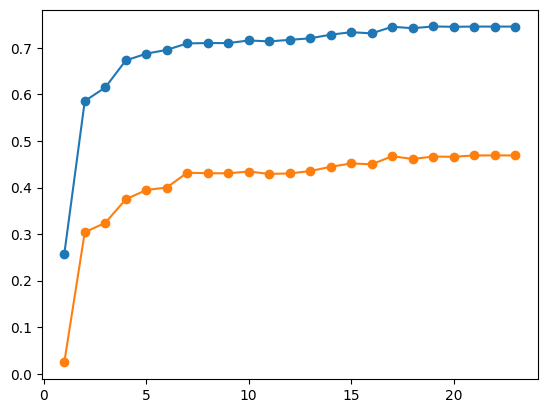

In [42]:
plt.plot(tot.FS,tot.acc,'o-',label='accuracy')
plt.plot(tot.FS,tot.mcc,'o-',label='MCC')

In [43]:
FS = int(tot.loc[tot.acc.argmax()].FS)
FS

19

In [44]:
test_area = labeled[labeled.skiarea_name==SKI_AREA_TEST]
test_area_small = labeled_small[labeled_small.skiarea_name==SKI_AREA_TEST]

test_area_season = labeled[(labeled.skiarea_name==SEASON_TEST_SKIAREA)&(labeled.season>=SEASON_TEST_YEAR)]
test_area_season_small = labeled_small[(labeled_small.skiarea_name==SEASON_TEST_SKIAREA)&(labeled_small.season>=SEASON_TEST_YEAR)]


In [46]:

if use_smote:
    dtrain_small_FS = xgb.DMatrix(X_train_smote_small[list(feat_imp.head(FS).index)],y_train_smote_small, 
                         enable_categorical=True,)
                        # weight=weight_train)
else:
    dtrain_small_FS = xgb.DMatrix(X_train_small[list(feat_imp.head(FS).index)],y_train_small, 
                         enable_categorical=True,
                         weight=weight_train)
dvalid_small_FS = xgb.DMatrix(X_valid_small[list(feat_imp.head(FS).index)],y_valid_small,
                     enable_categorical=True,
                     )


bst_small_FS = xgb.train(params_final, dtrain_small_FS,verbose_eval=False, num_boost_round=600,
                evals = [(dtrain_small_FS, "train"), (dvalid_small_FS, "valid")],
                early_stopping_rounds=100,)
dtest_small_FS = xgb.DMatrix(test_area_small[list(feat_imp.head(FS).index)],test_area_small.india,
                     enable_categorical=True,
                     )
dtest_season_small_FS = xgb.DMatrix(test_area_season_small[list(feat_imp.head(FS).index)],test_area_season_small.india,
                     enable_categorical=True,
                     )
preds_class_test = bst_small_FS.predict(dtest_small_FS)
preds_class_test_season = bst_small_FS.predict(dtest_season_small_FS)

mcc = matthews_corrcoef(test_area_small.india,preds_class_test.argmax(1))
acc = accuracy_score(test_area_small.india,preds_class_test.argmax(1))
cm = confusion_matrix(test_area_small.india,preds_class_test.argmax(1))

print(f'{mcc=}, {acc=}, \n{cm=}')
mcc = matthews_corrcoef(test_area_season_small.india,preds_class_test_season.argmax(1))
acc = accuracy_score(test_area_season_small.india,preds_class_test_season.argmax(1))
cm = confusion_matrix(test_area_season_small.india,preds_class_test_season.argmax(1))

print(f'{mcc=}, {acc=}, {cm=}')


mcc=0.3789808968443661, acc=0.7517207472959685, 
cm=array([[  39,   27,    1,    0,    0],
       [  45, 1275,  235,    1,    1],
       [   1,  175,  213,    7,    0],
       [   0,    0,   11,    2,    0],
       [   0,    0,    1,    0,    0]])
mcc=0.4520291259107882, acc=0.7425561154374714, cm=array([[  53,   14,    2,    0,    0],
       [  34, 1259,  369,    2,    2],
       [   0,  107,  306,   21,    0],
       [   0,    0,   11,    2,    0],
       [   0,    0,    0,    0,    1]])


In [96]:
test_area_small

Empty DataFrame
Columns: [skiarea_name, season, difficulty, cause, gender, equipment, helmet, destination, diagnosis, india, age, country, injury_side, injury_general_location, offroad_vehicle, quad, privat_helicopter, car, ski_lift, akja, other, indipendently, snowmobile, snowmobile_sled, ambulance, skiarea_ambulance, helicopter]
Index: []

[0 rows x 27 columns]

In [51]:
X_train_small.shape

(9455, 24)

In [53]:
X_valid_small.shape

(4658, 24)

In [40]:
import sys
sys.path.append('../') ##accrocchio
from src.utils import retrive_data,split
import pickle
#you can put these parameters in the args but here I keep it simpler
num_boost_round = 600
SKI_AREA_TEST= 'Klausberg'
SEASON_TEST_SKIAREA = 'Kronplatz'
SEASON_TEST_YEAR= 2023
weight_type = 'sqrt' 
## get the data
labeled,labeled_small,to_remove = retrive_data(reload_data=False,threshold_under_represented=0.5,path='/home/agobbi/Projects/PID/datanalytics/PID/src')
with open('to_remove.pkl','wb') as f:
    pickle.dump(to_remove,f)

#split the data
dataset,dataset_test = split(labeled_small  ,
                            SKI_AREA_TEST= SKI_AREA_TEST,
                            SEASON_TEST_SKIAREA = SEASON_TEST_SKIAREA,
                            SEASON_TEST_YEAR= SEASON_TEST_YEAR,
                            use_smote = False,
                            weight_type = weight_type )

   class          p
0      0   0.203424
1      1   0.013596
2      2   0.056109
3      3   1.130661
4      4  16.206137


In [45]:
labeled_small.shape

(18330, 27)

In [41]:
dataset_test.X_test_area.shape

(2034, 27)

In [42]:
dataset_test.X_test_season.shape

(2183, 27)

In [43]:
dataset.X_train.shape

(9455, 24)

In [44]:
dataset.X_valid.shape

(4658, 24)

In [46]:
9455+4658

14113

In [56]:
from optuna.visualization import plot_param_importances,plot_edf,plot_optimization_history,plot_intermediate_values,plot_parallel_coordinate,plot_edf
#plot_edf(study)
#plot_optimization_history(study)
with open('../src/best_params.pkl','rb') as f:
    params_final,feat_imp,best_model,study = pickle.load(f)


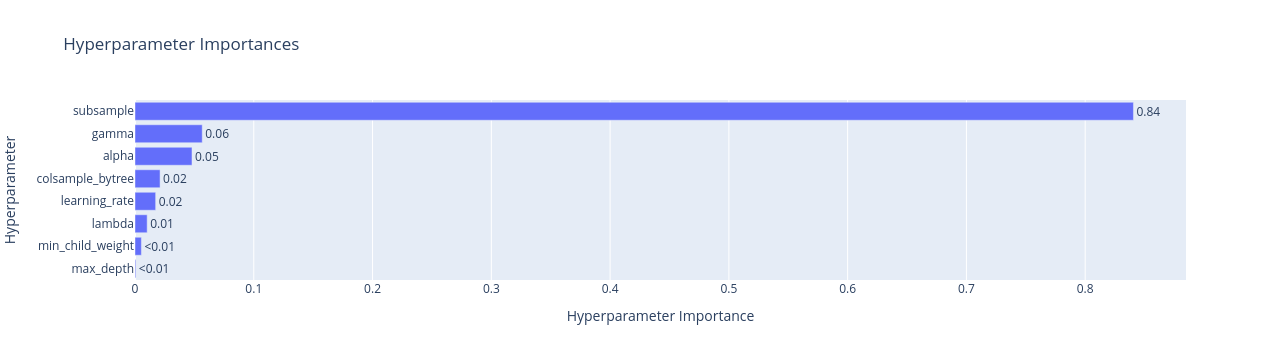

In [58]:
plot_param_importances(study)

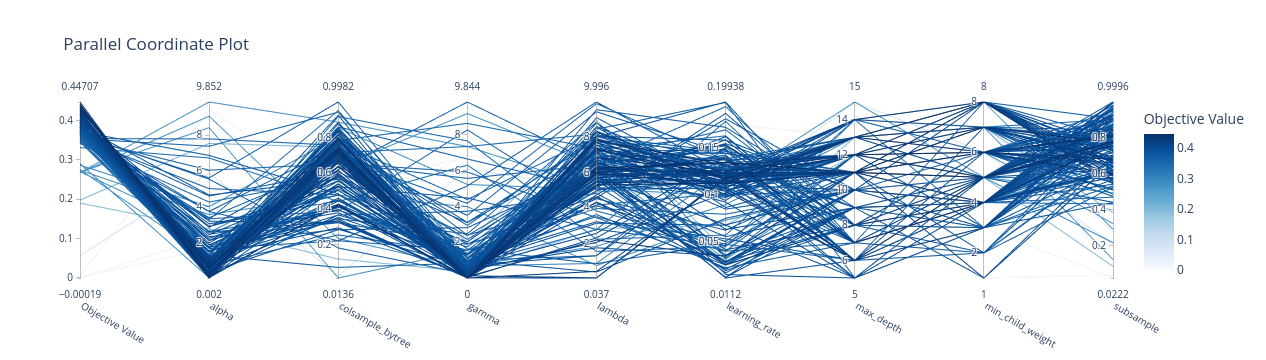

In [55]:
plot_parallel_coordinate(study)


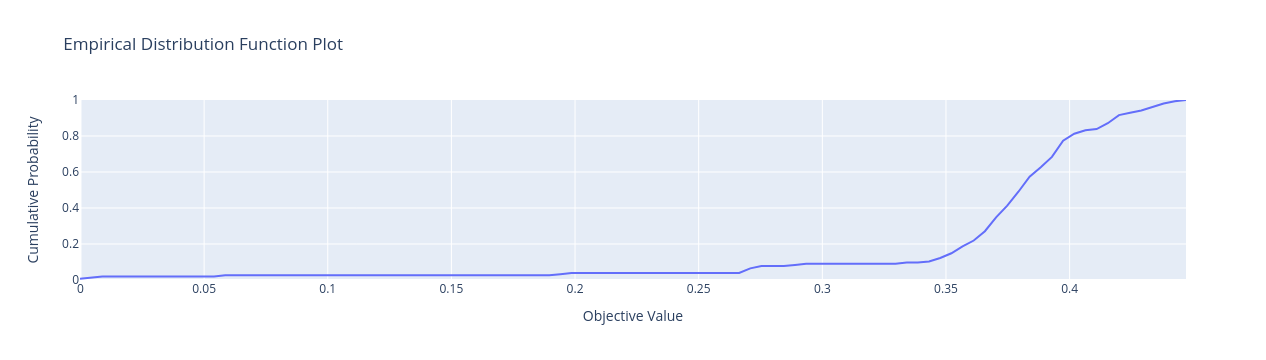

In [57]:
plot_edf(study)


In [59]:
with open('../src/best_params_and_final_model.pkl','rb') as f:
    tot,bst_FS,FS = pickle.load(f)  

In [97]:
tot.shape

(23, 3)

Text(18.5, 0.7783598110777159, 'ACC:0.71\nMCC:0.45')

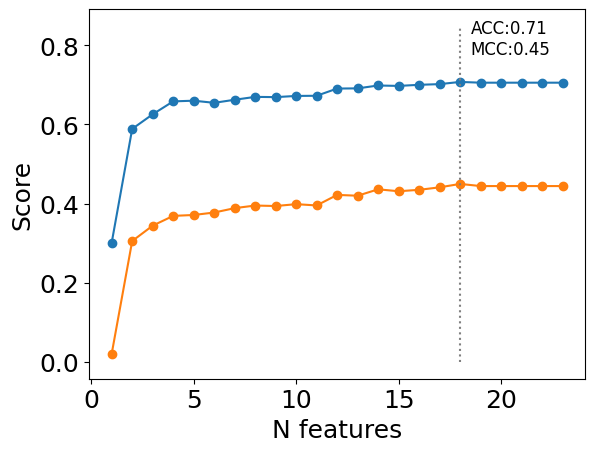

In [78]:
plt.plot(tot.FS, tot.acc,'o-', label='accuracy')
plt.plot(tot.FS, tot.mcc,'o-', label='MCC')
plt.xlabel('N features')
plt.ylabel('Score')
bacc = tot.acc[tot.FS==FS].values[0]
bmcc = tot.mcc[tot.FS==FS].values[0]
plt.vlines(x=FS, ymin=0, ymax=tot.acc.max()*1.2,color='gray',linestyles='dotted')
plt.text(x=FS+0.5, y=tot.acc.max()*1.1, s=f'ACC:{round(bacc,2)}\nMCC:{round(bmcc,2)}',fontdict={'size': 12})

In [98]:
feat_imp.shape

(19,)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, 'age'),
  Text(1, 0, 'diagnosis'),
  Text(2, 0, 'injury_general_location'),
  Text(3, 0, 'country'),
  Text(4, 0, 'difficulty'),
  Text(5, 0, 'destination'),
  Text(6, 0, 'cause'),
  Text(7, 0, 'injury_side'),
  Text(8, 0, 'gender'),
  Text(9, 0, 'snowmobile'),
  Text(10, 0, 'ambulance'),
  Text(11, 0, 'helicopter'),
  Text(12, 0, 'equipment'),
  Text(13, 0, 'indipendently'),
  Text(14, 0, 'akja'),
  Text(15, 0, 'ski_lift'),
  Text(16, 0, 'snowmobile_sled'),
  Text(17, 0, 'helmet'),
  Text(18, 0, 'skiarea_ambulance')])

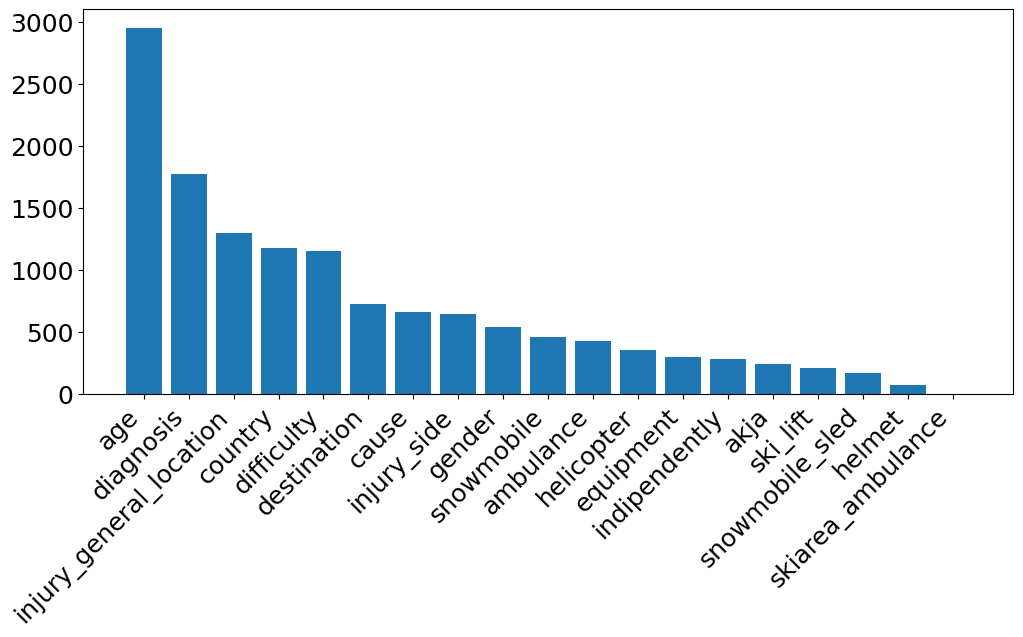

In [96]:
plt.figure(figsize= (12,5))
plt.bar(feat_imp.index,feat_imp.values,)
plt.xticks(rotation=45, ha='right')
#plt.vlines(x=FS, ymin=0, ymax=300,color='gray',linestyles='dotted')


In [99]:
dtest_FS = xgb.DMatrix(dataset_test.X_test_area[bst_FS.feature_names],dataset_test.y_test_area,enable_categorical=True,)
dtest_season_FS = xgb.DMatrix(dataset_test.X_test_season[bst_FS.feature_names],dataset_test.y_test_season,enable_categorical=True,)
preds_class_test = bst_FS.predict(dtest_FS)
preds_class_test_season = bst_FS.predict(dtest_season_FS)

mcc = matthews_corrcoef(dataset_test.y_test_area,preds_class_test.argmax(1))
acc = accuracy_score(dataset_test.y_test_area,preds_class_test.argmax(1))
cm = confusion_matrix(dataset_test.y_test_area,preds_class_test.argmax(1))

print(f'RESULT ON THE TEST SKI AREA {mcc=}, {acc=}, \n{cm=}')
mcc = matthews_corrcoef(dataset_test.y_test_season,preds_class_test_season.argmax(1))
acc = accuracy_score(dataset_test.y_test_season,preds_class_test_season.argmax(1))
cm = confusion_matrix(dataset_test.y_test_season,preds_class_test_season.argmax(1))

print(f'RESULT ON THE TEST SKI SEASON {mcc=}, {acc=}, {cm=}')

RESULT ON THE TEST SKI AREA mcc=0.353902218427158, acc=0.7143559488692232, 
cm=array([[  51,   15,    1,    0,    0],
       [ 104, 1189,  260,    2,    2],
       [   3,  164,  208,   21,    0],
       [   0,    0,    8,    5,    0],
       [   0,    0,    1,    0,    0]])
RESULT ON THE TEST SKI SEASON mcc=0.4284620408598895, acc=0.7095739807604214, cm=array([[  53,   11,    2,    0,    3],
       [  65, 1181,  400,   15,    5],
       [   0,   91,  308,   35,    0],
       [   0,    0,    7,    6,    0],
       [   0,    0,    0,    0,    1]])


In [102]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.5 MB/s eta 0:00:00MB/s eta 0:00:01


In [103]:
# -*- coding: utf-8 -*-
"""
plot a pretty confusion matrix with seaborn
Created on Mon Jun 25 14:17:37 2018
@author: Wagner Cipriano - wagnerbhbr - gmail - CEFETMG / MMC
REFerences:
  https://www.mathworks.com/help/nnet/ref/plotconfusion.html
  https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
  https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python
  https://www.programcreek.com/python/example/96197/seaborn.heatmap
  https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/31720054
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
"""

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from matplotlib.collections import QuadMesh


def get_new_fig(fn, figsize=[9, 9]):
    """Init graphics"""
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()  # Get Current Axis
    ax1.cla()  # clear existing plot
    return fig1, ax1


def configcell_text_and_colors(
    array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0
):
    """
    config cell text and colors
    and return text elements to add and to dell
    @TODO: use fmt
    """
    text_add = []
    text_del = []
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:, col]
    ccl = len(curr_column)

    # last line  and/or last column
    if (col == (ccl - 1)) or (lin == (ccl - 1)):
        # tots and percents
        if cell_val != 0:
            if (col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif col == ccl - 1:
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif lin == ccl - 1:
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]

        # text to DEL
        text_del.append(oText)

        # text to ADD
        font_prop = fm.FontProperties(weight="bold", size=fz)
        text_kwargs = dict(
            color="w",
            ha="center",
            va="center",
            gid="sum",
            fontproperties=font_prop,
        )
        lis_txt = ["%d" % (cell_val), per_ok_s, "%.2f%%" % (per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy()
        dic["color"] = "g"
        lis_kwa.append(dic)
        dic = text_kwargs.copy()
        dic["color"] = "r"
        lis_kwa.append(dic)
        lis_pos = [
            (oText._x, oText._y - 0.3),
            (oText._x, oText._y),
            (oText._x, oText._y + 0.3),
        ]
        for i in range(len(lis_txt)):
            newText = dict(
                x=lis_pos[i][0],
                y=lis_pos[i][1],
                text=lis_txt[i],
                kw=lis_kwa[i],
            )
            text_add.append(newText)

        # set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if (col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if per > 0:
            txt = "%s\n%.2f%%" % (cell_val, per)
        else:
            if show_null_values == 0:
                txt = ""
            elif show_null_values == 1:
                txt = "0"
            else:
                txt = "0\n0.0%"
        oText.set_text(txt)

        # main diagonal
        if col == lin:
            # set color of the textin the diagonal to white
            oText.set_color("w")
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color("r")

    return text_add, text_del


def insert_totals(df_cm):
    """insert total column and line (the last ones)"""
    sum_col = []
    for c in df_cm.columns:
        sum_col.append(df_cm[c].sum())
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append(item_line[1].sum())
    df_cm["sum_lin"] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc["sum_col"] = sum_col


def pp_matrix(
    df_cm,
    annot=True,
    cmap="Oranges",
    fmt=".2f",
    fz=11,
    lw=0.5,
    cbar=False,
    figsize=[8, 8],
    show_null_values=0,
    pred_val_axis="y",
):
    """
    print conf matrix with default layout (like matlab)
    params:
      df_cm          dataframe (pandas) without totals
      annot          print text in each cell
      cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
      fz             fontsize
      lw             linewidth
      pred_val_axis  where to show the prediction values (x or y axis)
                      'col' or 'x': show predicted values in columns (x axis) instead lines
                      'lin' or 'y': show predicted values in lines   (y axis)
    """
    if pred_val_axis in ("col", "x"):
        xlbl = "Predicted"
        ylbl = "Actual"
    else:
        xlbl = "Actual"
        ylbl = "Predicted"
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    # this is for print allways in the same window
    fig, ax1 = get_new_fig("Conf matrix default", figsize)

    ax = sn.heatmap(
        df_cm,
        annot=annot,
        annot_kws={"size": fz},
        linewidths=lw,
        ax=ax1,
        cbar=cbar,
        cmap=cmap,
        linecolor="w",
        fmt=fmt,
    )

    # set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=25, fontsize=10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    # iter in text elements
    array_df = np.array(df_cm.to_records(index=False).tolist())
    text_add = []
    text_del = []
    posi = -1  # from left to right, bottom to top.
    for t in ax.collections[0].axes.texts:  # ax.texts:
        pos = np.array(t.get_position()) - [0.5, 0.5]
        lin = int(pos[1])
        col = int(pos[0])
        posi += 1

        # set text
        txt_res = configcell_text_and_colors(
            array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values
        )

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    # remove the old ones
    for item in text_del:
        item.remove()
    # append the new ones
    for item in text_add:
        ax.text(item["x"], item["y"], item["text"], **item["kw"])

    # titles and legends
    ax.set_title("Confusion matrix")
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  # set layout slim
    plt.show()


def pp_matrix_from_data(
    y_test,
    predictions,
    columns=None,
    annot=True,
    cmap="Oranges",
    fmt=".2f",
    fz=11,
    lw=0.5,
    cbar=False,
    figsize=[8, 8],
    show_null_values=0,
    pred_val_axis="lin",
):
    """
    plot confusion matrix function with y_test (actual values) and predictions (predic),
    whitout a confusion matrix yet
    """
    from pandas import DataFrame
    from sklearn.metrics import confusion_matrix

    # data
    if not columns:
        from string import ascii_uppercase

        columns = [
            "class %s" % (i)
            for i in list(ascii_uppercase)[0 : len(np.unique(y_test))]
        ]

    confm = confusion_matrix(y_test, predictions)
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pp_matrix(
        df_cm,
        fz=fz,
        cmap=cmap,
        figsize=figsize,
        show_null_values=show_null_values,
        pred_val_axis=pred_val_axis,
    )

/tmp/ipykernel_20879/989477338.py:65: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



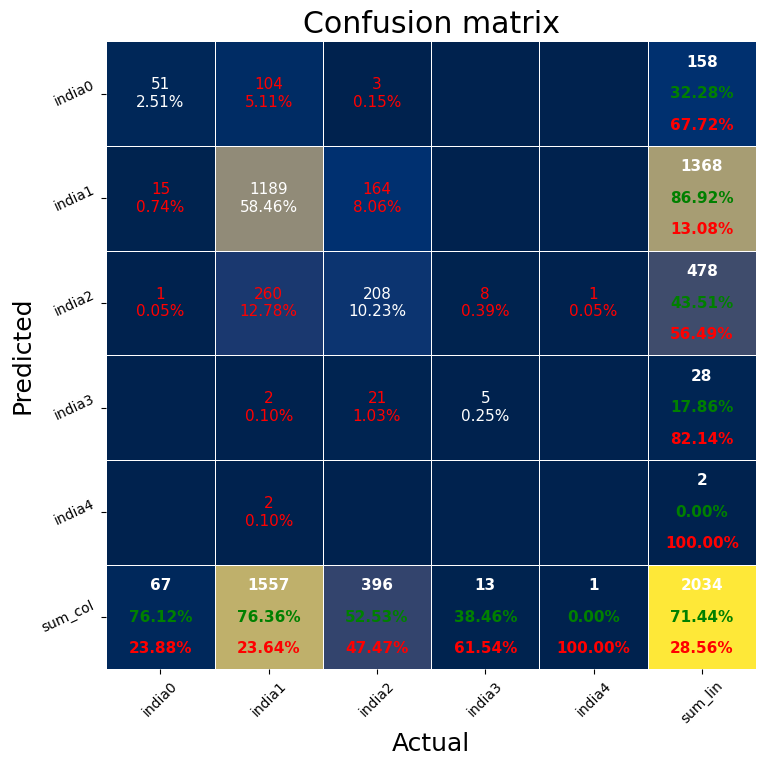

In [112]:
import numpy as np


pp_matrix_from_data(dataset_test.y_test_area,preds_class_test.argmax(1),cmap = 'cividis', columns=[f'india{i}' for i in range(5)])

/tmp/ipykernel_20879/989477338.py:65: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



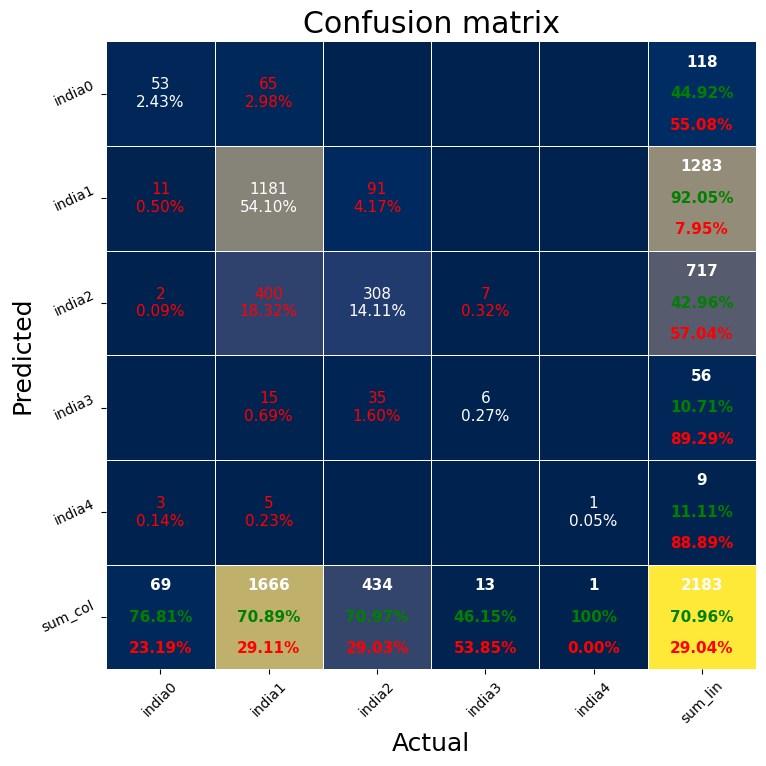

In [113]:
pp_matrix_from_data(dataset_test.y_test_season,preds_class_test_season.argmax(1),cmap = 'cividis', columns=[f'india{i}' for i in range(5)])